In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
!pip install scikit-learn==1.4.1.post1


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns

In [2]:
!mkdir AltStuff

#add data set

In [185]:
# Load the dataset
file_path = 'AltStuff/altitude_sickness_circulation.csv'
data = pd.read_csv(file_path)

In [186]:
#Dataset w eeg features
new_data = pd.read_csv('AltStuff/MEFAR_MID.csv')

In [5]:
new_data.columns.tolist()

['BVP',
 'EDA',
 'TEMP',
 'AccX',
 'AccY',
 'AccZ',
 'HR',
 ' Delta',
 ' Theta',
 ' Alpha1',
 ' Alpha2',
 ' Beta1',
 ' Beta2',
 ' Gamma1',
 ' Gamma2',
 ' Attention',
 ' Meditation',
 'class']

In [187]:
def match_records(data, new_data):
    matches = []

    for index, row in data.iterrows():
        # Count the number of symptoms greater than 1
        symptom_count = sum(row[feature] > 1 for feature in ['sym_headache', 'sym_gi', 'sym_fatigue', 'sym_dizziness'])

        # Determine the class condition based on the symptom count
        class_condition = 1 if symptom_count >= 2 else 0

        # Find matches where class matches the determined condition
        matching_indices = new_data['class'] == class_condition
        closest_matches = new_data[matching_indices]

        if not closest_matches.empty:
            # Randomly select a match if multiple matches are found
            closest_match_index = closest_matches.sample(1).index[0]
            matches.append((index, closest_match_index))
        else:
            # Print a message if no match is found
            print(f"No match found for data index {index} with class condition {class_condition}")

    return matches

# Assuming data and new_data are your DataFrame variables
matches = match_records(data, new_data)
print("Number of matches found:", len(matches))


Number of matches found: 188


In [188]:
# Trim leading/trailing spaces from the column names
new_data.columns = new_data.columns.str.strip()

# Now perform the match and data addition
for index, new_data_index in matches:
    try:
        # Make sure the column names here match the actual column names after stripping
        new_features = new_data.loc[new_data_index, ['BVP', 'EDA', 'TEMP',
                                                     'AccX', 'AccY', 'AccZ',
                                                     'Delta', 'Theta', 'Alpha1', 'Alpha2',
                                                     'Beta1', 'Beta2', 'Gamma1', 'Gamma2',
                                                     'Attention', 'Meditation', 'class']]
        data.loc[index, new_features.index] = new_features.values
        print(f"Features from new_data index {new_data_index} added to data index {index}.")
    except KeyError as e:
        print(f"Warning: Missing feature(s) {e} for index {new_data_index} in new_data")


Features from new_data index 820771 added to data index 0.
Features from new_data index 555634 added to data index 1.
Features from new_data index 163226 added to data index 2.
Features from new_data index 289060 added to data index 3.
Features from new_data index 527728 added to data index 4.
Features from new_data index 19749 added to data index 5.
Features from new_data index 634022 added to data index 6.
Features from new_data index 841123 added to data index 7.
Features from new_data index 103709 added to data index 8.
Features from new_data index 111976 added to data index 9.
Features from new_data index 727860 added to data index 10.
Features from new_data index 897866 added to data index 11.
Features from new_data index 866104 added to data index 12.
Features from new_data index 882437 added to data index 13.
Features from new_data index 96347 added to data index 14.
Features from new_data index 443578 added to data index 15.
Features from new_data index 305177 added to data in

In [92]:
data.to_csv('AltStuff/modified_data.csv', index=False)


In [189]:
print(new_data.columns)


Index(['BVP', 'EDA', 'TEMP', 'AccX', 'AccY', 'AccZ', 'HR', 'Delta', 'Theta',
       'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2', 'Attention',
       'Meditation', 'class'],
      dtype='object')


In [190]:
expected_columns = ['BVP', 'EDA', 'TEMP', 'AccX', 'AccY', 'AccZ',
                    'Delta', 'Theta', 'Alpha1', 'Alpha2',
                    'Beta1', 'Beta2', 'Gamma1', 'Gamma2',
                    'Attention', 'Meditation', 'class']
for col in expected_columns:
    if col in data.columns:
        print(f"Column {col} successfully added.")
    else:
        print(f"Column {col} missing.")

Column BVP successfully added.
Column EDA successfully added.
Column TEMP successfully added.
Column AccX successfully added.
Column AccY successfully added.
Column AccZ successfully added.
Column Delta successfully added.
Column Theta successfully added.
Column Alpha1 successfully added.
Column Alpha2 successfully added.
Column Beta1 successfully added.
Column Beta2 successfully added.
Column Gamma1 successfully added.
Column Gamma2 successfully added.
Column Attention successfully added.
Column Meditation successfully added.
Column class successfully added.


In [198]:
# Define a function to check for hypertension or diabetes
def check_illness(row, illness_list):
    illnesses = row[['past_illness_i', 'past_illness_ii', 'past_illness_iii']].astype(str).tolist()
    return any(illness in illnesses for illness in illness_list)

# Create binary indicators for hypertension and diabetes
hypertension_list = ['hypertension', 'high blood pressure', 'HBP']
diabetes_list = ['diabetes', 'high blood sugar', 'HBS']
data['hypertension'] = data.apply(lambda row: check_illness(row, hypertension_list), axis=1).astype(int)
data['diabetes'] = data.apply(lambda row: check_illness(row, diabetes_list), axis=1).astype(int)

# Prepare the target variable based on Lake Louise Score (LLS)
data['AMS'] = np.where(data['lls_score'] >= 3, 1, 0)

# Define additional features
additional_features = ['ascent_day', 'smoking', 'sym_headache', 'sym_gi', 'sym_fatigue', 'sym_dizziness',
                       'alt_gain_from_altitude', 'alt_gain_to_altitude', 'temp']

# Define selected features
selected_features = [
    'age', 'gender', 'permanent_altitude', 'bp_systolic', 'bp_diastolic',
    'spo2', 'pulse', 'hypertension', 'diabetes'
] + additional_features + ['BVP', 'EDA',
                                                  'AccX', 'AccY', 'AccZ']

# ['BVP', 'EDA', 'TEMP',
#                                                   'AccX', 'AccY', 'AccZ',  # Add more features
#                                                   'Delta', 'Theta', 'Alpha1', 'Alpha2',
#                                                   'Beta1', 'Beta2', 'Gamma1', 'Gamma2',
#                                                   'Attention', 'Meditation', 'class']

# Extract selected features
X = data[selected_features]
y = data['AMS']

# Identifying categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


knn_classifier = KNeighborsClassifier()
param_grid_classifier = {
    'n_neighbors': [3, 5, 7, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
}


grid_search_classifier = GridSearchCV(knn_classifier, param_grid_classifier, cv=7, scoring='accuracy')
pipeline_classifier = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('grid_search', grid_search_classifier)])

# Split the data into training and test sets
X_train, X_test, y_train_class, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit the model
pipeline_classifier.fit(X_train, y_train_class)

# Make predictions and evaluate the model
preds = pipeline_classifier.predict(X_test)
score = accuracy_score(y_test, preds)
report = classification_report(y_test, preds)

print("Accuracy:", score)
print("Classification Report:\n", report)


Accuracy: 0.9122807017543859
Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92        29
           1       1.00      0.82      0.90        28

    accuracy                           0.91        57
   macro avg       0.93      0.91      0.91        57
weighted avg       0.93      0.91      0.91        57



In [197]:
from sklearn.metrics import mean_squared_error, r2_score


# Define a function to check for hypertension or diabetes
def check_illness(row, illness_list):
    illnesses = row[['past_illness_i', 'past_illness_ii', 'past_illness_iii']].astype(str).tolist()
    return any(illness in illnesses for illness in illness_list)

# Create binary indicators for hypertension and diabetes
hypertension_list = ['hypertension', 'high blood pressure', 'HBP']
diabetes_list = ['diabetes', 'high blood sugar', 'HBS']
data['hypertension'] = data.apply(lambda row: check_illness(row, hypertension_list), axis=1).astype(int)
data['diabetes'] = data.apply(lambda row: check_illness(row, diabetes_list), axis=1).astype(int)


# Define additional features
additional_features = ['ascent_day', 'smoking', 'sym_headache', 'sym_gi', 'sym_fatigue', 'sym_dizziness',
                       'alt_gain_from_altitude', 'alt_gain_to_altitude', 'temp']

# Define selected features
selected_features = [
    'age', 'gender', 'permanent_altitude', 'bp_systolic', 'bp_diastolic',
    'spo2', 'pulse', 'hypertension', 'diabetes'
] + additional_features + ['BVP', 'EDA', 'Theta', 'Alpha1', 'Beta1']

# ['BVP', 'EDA', 'TEMP',
#                                                   'AccX', 'AccY', 'AccZ',  # Add more features
#                                                   'Delta', 'Theta', 'Alpha1', 'Alpha2',
#                                                   'Beta1', 'Beta2', 'Gamma1', 'Gamma2',
#                                                   'Attention', 'Meditation', 'class']

# Extract selected features
X = data[selected_features]
# Replace 'AMS' with 'lls_score' as the target variable
y = data['lls_score'].fillna(data['lls_score'].mean())  # Filling missing values with the mean


# Identifying categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


param_grid_regressor_expanded = {
    'n_neighbors': [3, 5, 7, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
}
knn_regressor = KNeighborsRegressor()
grid_search_regressor_expanded = GridSearchCV(knn_regressor, param_grid_regressor_expanded, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

pipeline_regressor = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('grid_search', grid_search_regressor_expanded)])

# Split the data into training and test sets for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit the regression model
pipeline_regressor.fit(X_train_reg, y_train_reg)

# Make predictions and evaluate the regression model
preds_reg = pipeline_regressor.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, preds_reg)
r2 = r2_score(y_test_reg, preds_reg)

print("Best Parameters:", pipeline_regressor.named_steps['grid_search'].best_params_)
print("Mean Squared Error:", mse)
print("R-squared:", r2)



Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Mean Squared Error: 0.35879613793962895
R-squared: 0.8189132393456646


In [202]:
import pickle

# Assuming 'pipeline' is your trained model
with open('knn_model.pkl', 'wb') as file:
    pickle.dump(pipeline_regressor, file)

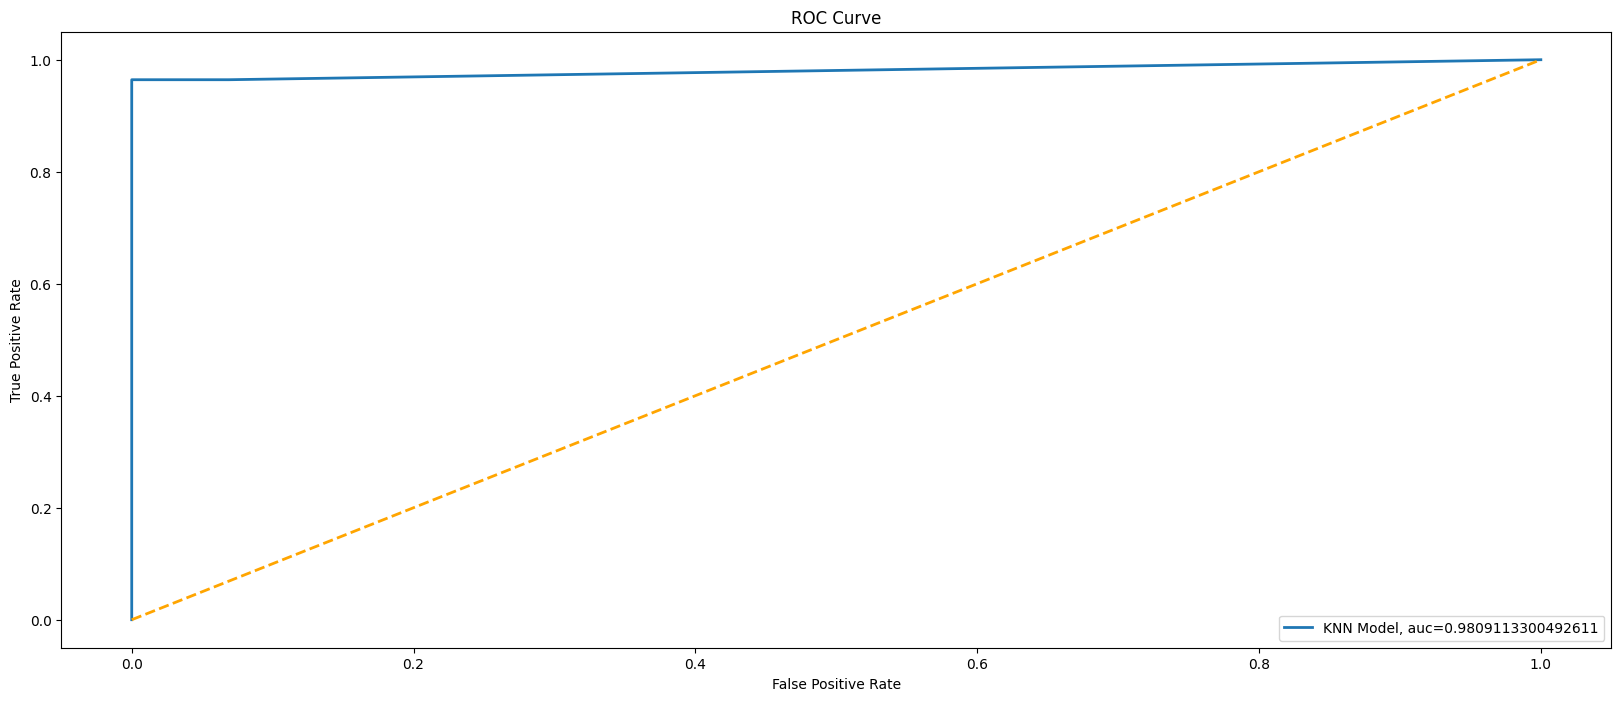

In [71]:
# For ROC Curve, you need probabilities of the positive class
y_pred_probs = pipeline_classifier.predict_proba(X_test)[:, 1]

# ROC Curve and AUC Score
plt.figure(figsize=(20, 8))
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
auc = roc_auc_score(y_test, y_pred_probs)
plt.plot(fpr, tpr, label="KNN Model, auc=" + str(auc), lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

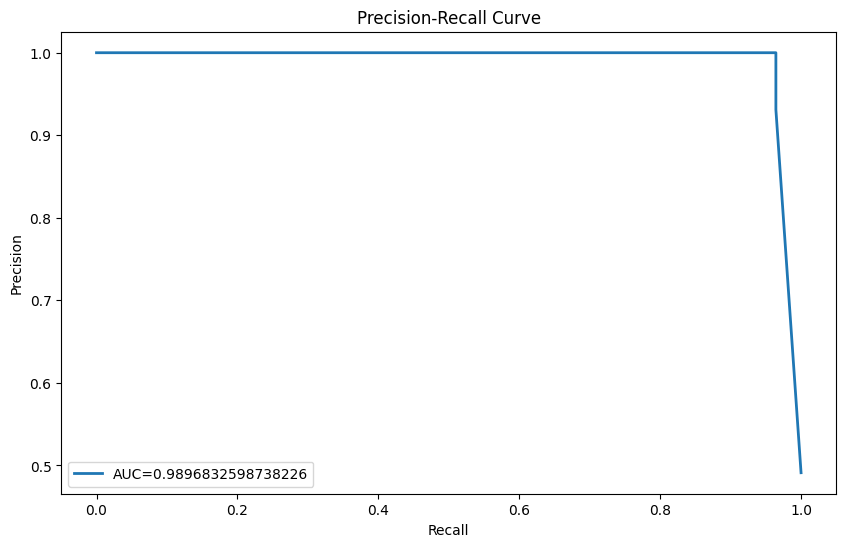

In [72]:
# Ensure your KNN model can return probabilities
# Note: Standard KNeighborsClassifier supports predict_proba method

# Predict probabilities for the positive class
y_pred_proba = pipeline_classifier.predict_proba(X_test)[:, 1]

# Now generate the Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auc_score = auc(recall, precision)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label="AUC="+str(auc_score), lw=2)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


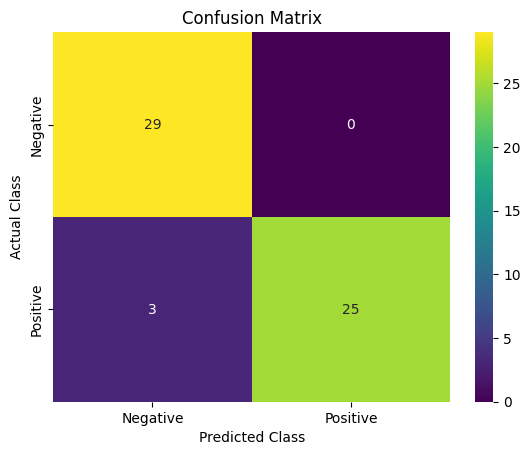

In [73]:
# Confusion Matrix
y_pred = pipeline_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, cmap='viridis', annot=True, fmt='g',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()

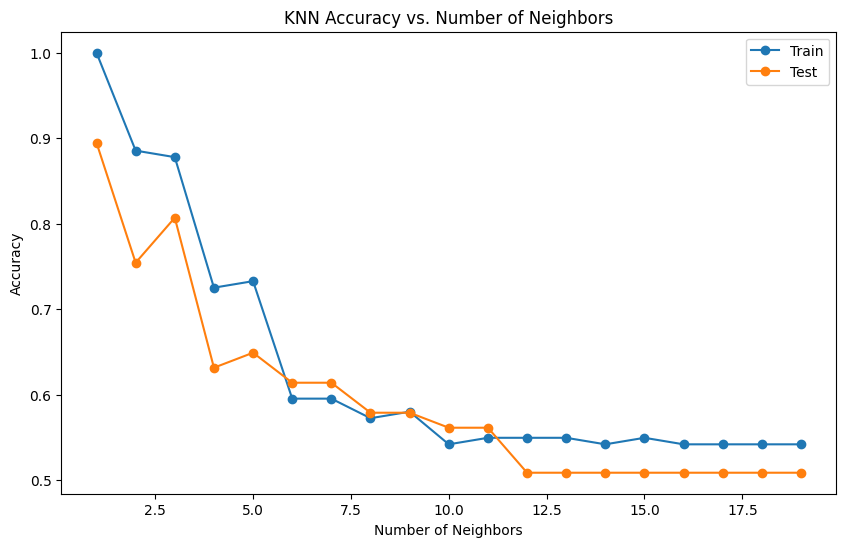

In [74]:
import matplotlib.pyplot as plt

neighbor_range = range(1, 20)  # or any range of n_neighbors you're interested in
train_scores, test_scores = list(), list()

# Assuming you have a preprocessor set up as before
for n in neighbor_range:
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('knn', KNeighborsClassifier(n_neighbors=n))])
    model.fit(X_train, y_train_class)

    train_scores.append(model.score(X_train, y_train_class))
    test_scores.append(model.score(X_test, y_test))


plt.figure(figsize=(10, 6))
plt.plot(neighbor_range, train_scores, label='Train', marker='o')
plt.plot(neighbor_range, test_scores, label='Test', marker='o')
plt.title('KNN Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [75]:
# Make predictions and evaluate the model
preds = pipeline_classifier.predict(X_test)
score = accuracy_score(y_test, preds)
report = classification_report(y_test, preds)

print("Accuracy:", score)
print("Classification Report:\n", report)


Accuracy: 0.9473684210526315
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        29
           1       1.00      0.89      0.94        28

    accuracy                           0.95        57
   macro avg       0.95      0.95      0.95        57
weighted avg       0.95      0.95      0.95        57



In [66]:
import pickle

# Assuming 'pipeline' is your trained model
with open('knn_model.pkl', 'wb') as file:
    pickle.dump(pipeline_classifier, file)

In [172]:
import pandas as pd

# Sample input data (replace with actual values later)
sample_data = {
    'age': [50],  # Age of the individual
    'gender': ['M'],  # Gender: 'M' for male, 'F' for female
    'temp': [97],  # Temperature in degrees Celsius (normal body temperature)
    'bp_systolic': [90],  # Systolic blood pressure (normal range)
    'bp_diastolic': [70],  # Diastolic blood pressure (normal range)
    'spo2': [98],  # Blood oxygen saturation in percentage (normal range)
    'pulse': [90],  # Pulse rate in beats per minute (normal range)
    'hypertension': [1],  # 0 if the individual does not have hypertension
    'diabetes': [1],  # 0 if the individual does not have diabetes
    'permanent_altitude': [1000],  # Altitude of permanent residence in meters (example)
    'alt_gain_from_altitude': [1],  # Altitude gain from starting point (example)
    'alt_gain_to_altitude': [100],  # Altitude gain to end point (example)
    'ascent_day': [7],  # Number of days spent ascending to current altitude
    'smoking': [0],  # 0 if the individual does not smoke
    'sym_headache': [1],  # 0 if not experiencing headache
    'sym_gi': [0],  # 0 if not experiencing gastrointestinal distress
    'sym_fatigue': [0],  # 0 if not experiencing fatigue
    'sym_dizziness': [0],  # 0 if not experiencing dizziness
    'BVP': [-0.25],  # Blood Volume Pulse (example value)
    'EDA': [-0.96],  # Electrodermal Activity (example value)
    'AccX': [-0.53],  # Accelerometer X-axis (example value)
    'AccY': [-0.14],  # Accelerometer Y-axis (example value)
    'AccZ': [-0.14],  # Accelerometer Z-axis (example value)
}

# Convert sample data to DataFrame
sample_input_df = pd.DataFrame(sample_data)

# Assuming your preprocessor and model pipeline (named 'pipeline_classifier') are already defined and trained

# Preprocess the sample input
processed_sample_input = pipeline_classifier.named_steps['preprocessor'].transform(sample_input_df)

# Get the probability of AMS risk
predicted_prob = pipeline_classifier.named_steps['grid_search'].best_estimator_.predict_proba(processed_sample_input)

# Output the probability for the positive class (assuming '1' represents high risk)
ams_risk_probability = predicted_prob[0][1] * 100  # Multiply by 100 to get a percentage

# Adjust the LLS score scaling
min_prob_for_scaling = 20  # 20% probability corresponds to LLS score of 0
max_lls_score = 12

if ams_risk_probability <= min_prob_for_scaling:
    scaled_lls_score = 0
else:
    # Scale the probability above 20% to the LLS score range (0 to 12)
    scaled_lls_score = round((ams_risk_probability) / (100) * max_lls_score)

print("Probability of high AMS risk:", ams_risk_probability, "%")
print("Approximated LLS score:", scaled_lls_score)

Probability of high AMS risk: 33.230919461622314 %
Approximated LLS score: 4


In [200]:
import pandas as pd

# Sample input data (replace with actual values later)
sample_data = {
    'age': [27],  # Age of the individual
    'gender': ['F'],  # Gender: 'M' for male, 'F' for female
    'temp': [97],  # Temperature in degrees Celsius (normal body temperature)
    'bp_systolic': [100],  # Systolic blood pressure (normal range)
    'bp_diastolic': [110],  # Diastolic blood pressure (normal range)
    'spo2': [98],  # Blood oxygen saturation in percentage (normal range)
    'pulse': [90],  # Pulse rate in beats per minute (normal range)
    'hypertension': [1],  # 0 if the individual does not have hypertension
    'diabetes': [1],  # 0 if the individual does not have diabetes
    'permanent_altitude': [6000],  # Altitude of permanent residence in meters (example)
    'alt_gain_from_altitude': [800],  # Altitude gain from starting point (example)
    'alt_gain_to_altitude': [3800],  # Altitude gain to end point (example)
    'ascent_day': [1],  # Number of days spent ascending to current altitude
    'smoking': [1],  # 0 if the individual does not smoke
    'sym_headache': [2],  # 0 if not experiencing headache
    'sym_gi': [0],  # 0 if not experiencing gastrointestinal distress
    'sym_fatigue': [0],  # 0 if not experiencing fatigue
    'sym_dizziness': [0],  # 0 if not experiencing dizziness
    'BVP': [-0.15],  # Blood Volume Pulse (example value)
    'EDA': [0.02],  # Electrodermal Activity (example value)
    'Theta': [0.02],
    'Alpha1': [0.01],
    'Beta1': [0.02],
}

# Convert sample data to DataFrame
sample_input_df = pd.DataFrame(sample_data)

# Assuming your preprocessor and model pipeline (named 'pipeline_regressor') are already defined and trained

# Preprocess the sample input
processed_sample_input = pipeline_regressor.named_steps['preprocessor'].transform(sample_input_df)

# Predict the LLS score using the regression model
predicted_lls_score = pipeline_regressor.named_steps['grid_search'].best_estimator_.predict(processed_sample_input)

# Output the predicted LLS score
print("Predicted LLS score:", predicted_lls_score[0])


Predicted LLS score: 2.6909801522867602
